# Lab 12. Proyecto de Consultoría - Clustering

- José Mérida
- Joaquín Puente

# Setup de Spark

## Imports e Inicio de Sesión en Spark
Primero iniciamos importando algunas librerías baseline, al igual que Spark para poder correr este Notebook.

## Imports de Librerías

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Inicio de Sesión de Spark

In [2]:
spark = SparkSession.builder \
    .appName("HackerClusteringAnalysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Session iniciada exitosamente!")
print(f"Versión de Spark: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/31 16:38:36 WARN Utils: Your hostname, ArchJapo, resolves to a loopback address: 127.0.1.1; using 10.100.14.123 instead (on interface wlp0s20f3)
25/10/31 16:38:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/31 16:38:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session iniciada exitosamente!
Versión de Spark: 4.0.1


# Carga y Descripción de los Datos
En esta parte estaremos cargando los datos y dando un vistazo inicial.

## Carga del CSV y Visualización Esquema
Primero, utilizamos la lectura de CSV con inferSchema y header para cargar el conjunto de datos con los nombres de columna y tipos correctos.

In [3]:
df = spark.read.csv("hack_data.csv", header=True, inferSchema=True)

df.printSchema()
print(f"Total de filas: {df.count()}")
print(f"Total de columnas: {len(df.columns)}")

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)

Total de filas: 334
Total de columnas: 7


Como podemos ver, el esquema se ha cargado correctamente utilizando los headers y los tipos inferidos del archivo .csv. Adicionalmente, tenemos la siguiente información sobre las variables proveídas para el proyecto de consultoría:

- **Session_Connection_Time**: Numérico, representa el tiempo de conexión de la sesión en minutos.
- **Bytes Transferred**: Numérico, cantidad de bytes transferidos durante la sesión.
- **Kali_Trace_Used**: Binario (0/1), indica si se utilizó Kali Trace durante el ataque.
- **Servers_Corrupted**: Numérico, cantidad de servidores corrompidos.
- **Pages_Corrupted**: Numérico, cantidad de páginas corrompidas.
- **Location**: String, ubicación geográfica del atacante.
- **WPM_Typing_Speed**: Numérico, velocidad de escritura en palabras por minuto.

## Inspección Primeras Filas
Aquí podemos usar df.show() para tener una vista un poco más a profundidad sobre como se ve el dataset.

In [4]:
df.show(10)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

Los datos se ven como esperados, donde cada fila representa una sesión de hackeo con información sobre las diferentes variables de comportamiento. Podemos observar que:

- Las variables numéricas tienen diferentes escalas, por lo que será necesario estandarizar.
- La variable Location contiene nombres de países, que podríamos usar para análisis geográfico.
- Kali_Trace_Used es binaria (0 o 1), lo cual es correcto para nuestro análisis.

# Limpieza Básica
En esta sección estaremos realizando unas operaciones de limpieza básica, entre ellas:

- Remover valores nulos o sin sentido
- Verificar la existencia de duplicados
- Estandarizar texto
- Verificar rangos correctos en variables numéricas

## Valores Nulos / Ilógicos
Aquí simplemente podemos realizar algunos checks con counts para valores nulos, al igual que algunas variables donde no tendría sentido que fueran negativas.

In [5]:
print("Conteo de valores nulos por columna:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Conteo de valores nulos por columna:
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|                      0|                0|              0|                0|              0|       0|               0|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+



Verificamos que no contamos con valores nulos. Ahora vamos a verificar que las variables numéricas tengan valores lógicos (no negativos donde no deberían).

In [6]:
numeric_cols = ["Session_Connection_Time", "Bytes Transferred", "Servers_Corrupted", 
                "Pages_Corrupted", "WPM_Typing_Speed"]

print("Conteo de valores negativos por columna:")
df.select([count(when(col(c) < 0, c)).alias(c) for c in numeric_cols]).show()

Conteo de valores negativos por columna:
+-----------------------+-----------------+-----------------+---------------+----------------+
|Session_Connection_Time|Bytes Transferred|Servers_Corrupted|Pages_Corrupted|WPM_Typing_Speed|
+-----------------------+-----------------+-----------------+---------------+----------------+
|                      0|                0|                0|              0|               0|
+-----------------------+-----------------+-----------------+---------------+----------------+



Verificamos que no existen valores negativos en variables donde estos no tendrían sentido lógico.

## Valores Duplicados
Aquí podemos identificar valores duplicados por medio de la diferencia de tamaño entre el dataset original y su versión sin duplicados.

In [7]:
print("Filas duplicadas:")
duplicates = df.count() - df.dropDuplicates().count()
print(f"Número de filas duplicadas: {duplicates}")

Filas duplicadas:
Número de filas duplicadas: 0


Verificamos la cantidad de filas duplicadas en el dataset.

## Estandarización de Texto

### Estandarización Location
Empezamos listando las diferentes entradas únicas para la columna Location.

In [8]:
print(f"Número de ubicaciones únicas: {df.select('Location').distinct().count()}")
df.select("Location").distinct().orderBy("Location").show(20, truncate=False)

Número de ubicaciones únicas: 181
+--------------------------------------------+
|Location                                    |
+--------------------------------------------+
|Afghanistan                                 |
|Albania                                     |
|Algeria                                     |
|Andorra                                     |
|Anguilla                                    |
|Antarctica (the territory South of 60 deg S)|
|Antigua and Barbuda                         |
|Armenia                                     |
|Australia                                   |
|Austria                                     |
|Azerbaijan                                  |
|Bahamas                                     |
|Bangladesh                                  |
|Belarus                                     |
|Belgium                                     |
|Belize                                      |
|Benin                                       |
|Bhutan                   

Podemos observar las diferentes ubicaciones en el dataset. Vamos a estandarizar el texto convirtiéndolo a minúsculas y eliminando espacios adicionales.

In [9]:
df = df.withColumn("Location", lower(trim(col("Location"))))
print("Ubicaciones después de estandarización:")
df.select("Location").distinct().orderBy("Location").show(20, truncate=False)

Ubicaciones después de estandarización:


+--------------------------------------------+
|Location                                    |
+--------------------------------------------+
|afghanistan                                 |
|albania                                     |
|algeria                                     |
|andorra                                     |
|anguilla                                    |
|antarctica (the territory south of 60 deg s)|
|antigua and barbuda                         |
|armenia                                     |
|australia                                   |
|austria                                     |
|azerbaijan                                  |
|bahamas                                     |
|bangladesh                                  |
|belarus                                     |
|belgium                                     |
|belize                                      |
|benin                                       |
|bhutan                                      |
|bolivia     

### Nombres de Columnas
Vamos a estandarizar los nombres de columnas para tener un formato consistente.

In [10]:
# Reemplazar espacios con guiones bajos y convertir a minúsculas
df = df.toDF(*[c.replace(" ", "_").lower() for c in df.columns])
df.printSchema()

root
 |-- session_connection_time: double (nullable = true)
 |-- bytes_transferred: double (nullable = true)
 |-- kali_trace_used: integer (nullable = true)
 |-- servers_corrupted: double (nullable = true)
 |-- pages_corrupted: double (nullable = true)
 |-- location: string (nullable = true)
 |-- wpm_typing_speed: double (nullable = true)



El esquema ya cuenta con nombres consistentes de columnas, por lo que podemos proceder al EDA.

# EDA (Análisis Exploratorio de Datos)

## Session Connection Time

### Distribución

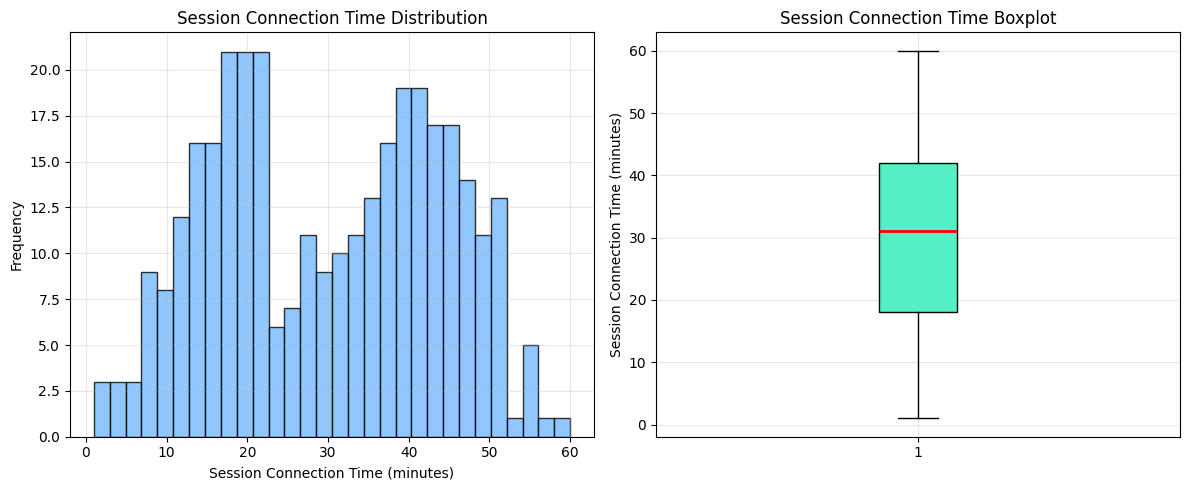

+-------+-----------------------+
|summary|session_connection_time|
+-------+-----------------------+
|  count|                    334|
|   mean|     30.008982035928145|
| stddev|     14.088200614636158|
|    min|                    1.0|
|    max|                   60.0|
+-------+-----------------------+



In [11]:
session_times = df.select("session_connection_time").rdd.flatMap(lambda x: x).collect()

hist_color = "#74b9ff"
box_color = "#55efc4"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(session_times, bins=30, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Session Connection Time Distribution")
axes[0].set_xlabel("Session Connection Time (minutes)")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(session_times, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Session Connection Time Boxplot")
axes[1].set_ylabel("Session Connection Time (minutes)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
df.select("session_connection_time").describe().show()

Podemos observar la distribución del tiempo de conexión de las sesiones. Esta variable puede ser importante para identificar patrones de comportamiento de diferentes tipos de atacantes.

## Bytes Transferred

### Distribución

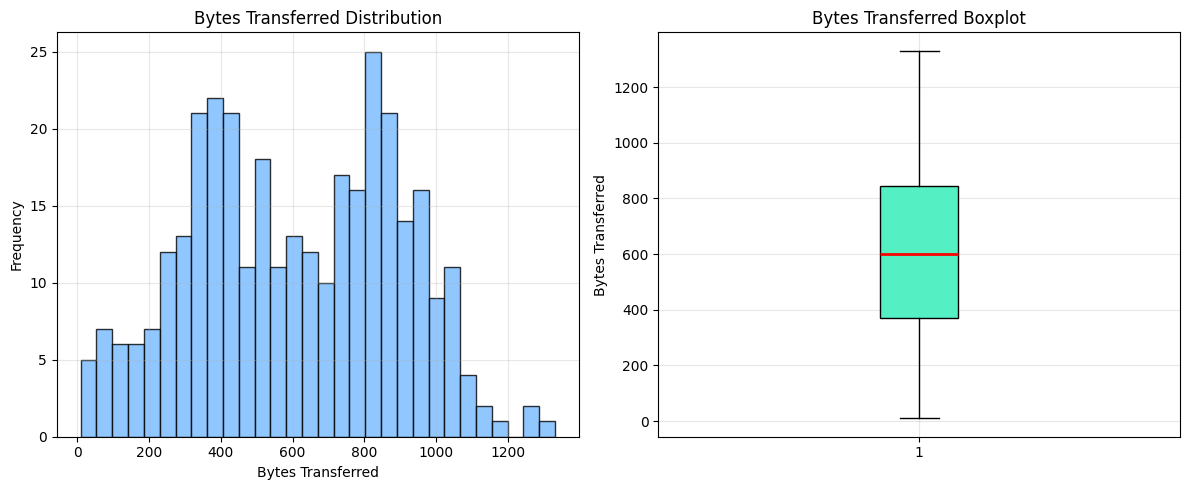

+-------+------------------+
|summary| bytes_transferred|
+-------+------------------+
|  count|               334|
|   mean| 607.2452694610777|
| stddev|286.33593163576757|
|    min|              10.0|
|    max|            1330.5|
+-------+------------------+



In [12]:
bytes_data = df.select("bytes_transferred").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(bytes_data, bins=30, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Bytes Transferred Distribution")
axes[0].set_xlabel("Bytes Transferred")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(bytes_data, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Bytes Transferred Boxplot")
axes[1].set_ylabel("Bytes Transferred")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

df.select("bytes_transferred").describe().show()

La cantidad de bytes transferidos puede indicar diferentes tipos de ataques - algunos pueden transferir grandes cantidades de datos mientras que otros pueden ser más sigilosos.

## Kali Trace Used

### Distribución

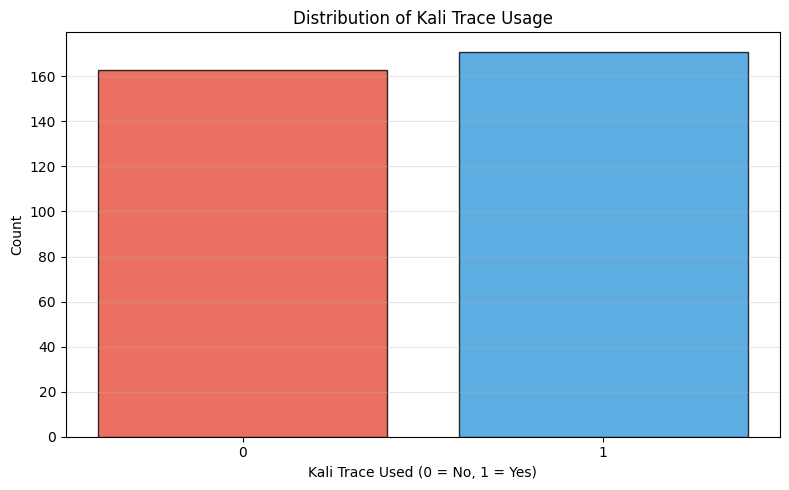


Conteo de Kali Trace Used:
+---------------+-----+
|kali_trace_used|count|
+---------------+-----+
|              0|  163|
|              1|  171|
+---------------+-----+



In [13]:
kali_counts = df.groupBy("kali_trace_used").count().orderBy("kali_trace_used").toPandas()

plt.figure(figsize=(8, 5))
plt.bar(kali_counts["kali_trace_used"].astype(str), kali_counts["count"], 
        color=["#e74c3c", "#3498db"], edgecolor="black", alpha=0.8)
plt.title("Distribution of Kali Trace Usage")
plt.xlabel("Kali Trace Used (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\nConteo de Kali Trace Used:")
df.groupBy("kali_trace_used").count().orderBy("kali_trace_used").show()

Esta variable binaria indica si se utilizó Kali Trace. La distribución entre ambas categorías puede ayudar a identificar diferentes perfiles de atacantes.

## Servers Corrupted

### Distribución

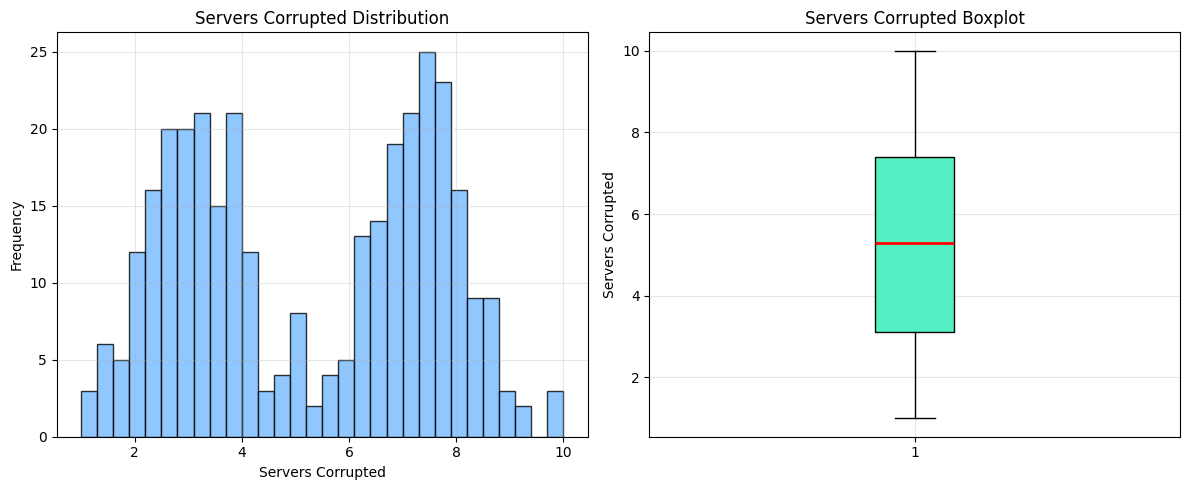

+-------+-----------------+
|summary|servers_corrupted|
+-------+-----------------+
|  count|              334|
|   mean|5.258502994011977|
| stddev| 2.30190693339697|
|    min|              1.0|
|    max|             10.0|
+-------+-----------------+



In [14]:
servers_data = df.select("servers_corrupted").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(servers_data, bins=30, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Servers Corrupted Distribution")
axes[0].set_xlabel("Servers Corrupted")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(servers_data, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Servers Corrupted Boxplot")
axes[1].set_ylabel("Servers Corrupted")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

df.select("servers_corrupted").describe().show()

La cantidad de servidores corrompidos puede ser un indicador clave del nivel de sofisticación y alcance del ataque.

## Pages Corrupted

### Distribución

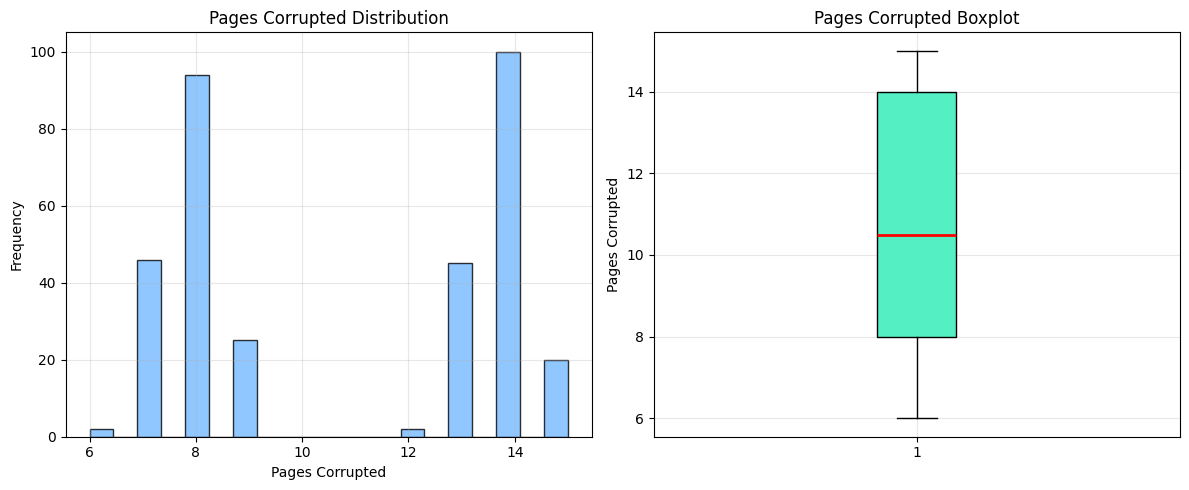

+-------+------------------+
|summary|   pages_corrupted|
+-------+------------------+
|  count|               334|
|   mean|10.838323353293413|
| stddev|  3.06352633036022|
|    min|               6.0|
|    max|              15.0|
+-------+------------------+



In [15]:
pages_data = df.select("pages_corrupted").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(pages_data, bins=20, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Pages Corrupted Distribution")
axes[0].set_xlabel("Pages Corrupted")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(pages_data, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Pages Corrupted Boxplot")
axes[1].set_ylabel("Pages Corrupted")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

df.select("pages_corrupted").describe().show()

Observamos la distribución de páginas corrompidas. Podemos notar si existen valores atípicos que indiquen ataques particularmente agresivos.

## WPM Typing Speed

### Distribución

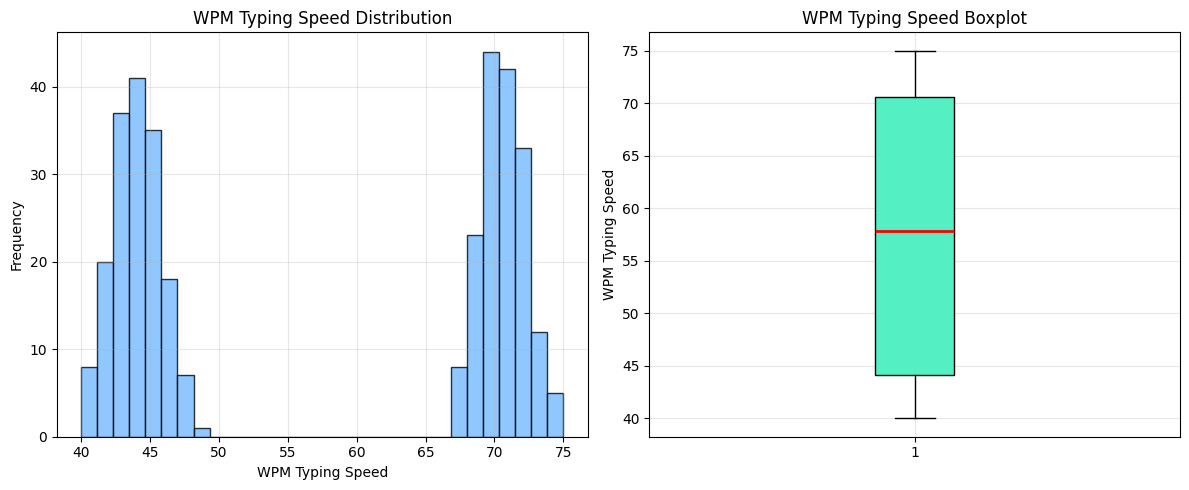

+-------+------------------+
|summary|  wpm_typing_speed|
+-------+------------------+
|  count|               334|
|   mean|57.342395209580864|
| stddev| 13.41106336843464|
|    min|              40.0|
|    max|              75.0|
+-------+------------------+



In [16]:
wpm_data = df.select("wpm_typing_speed").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(wpm_data, bins=30, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("WPM Typing Speed Distribution")
axes[0].set_xlabel("WPM Typing Speed")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(wpm_data, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("WPM Typing Speed Boxplot")
axes[1].set_ylabel("WPM Typing Speed")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

df.select("wpm_typing_speed").describe().show()

La velocidad de escritura puede ser un indicador interesante del nivel de experiencia del atacante. Velocidades muy altas o muy bajas pueden indicar diferentes perfiles.

## Location (Análisis Geográfico)

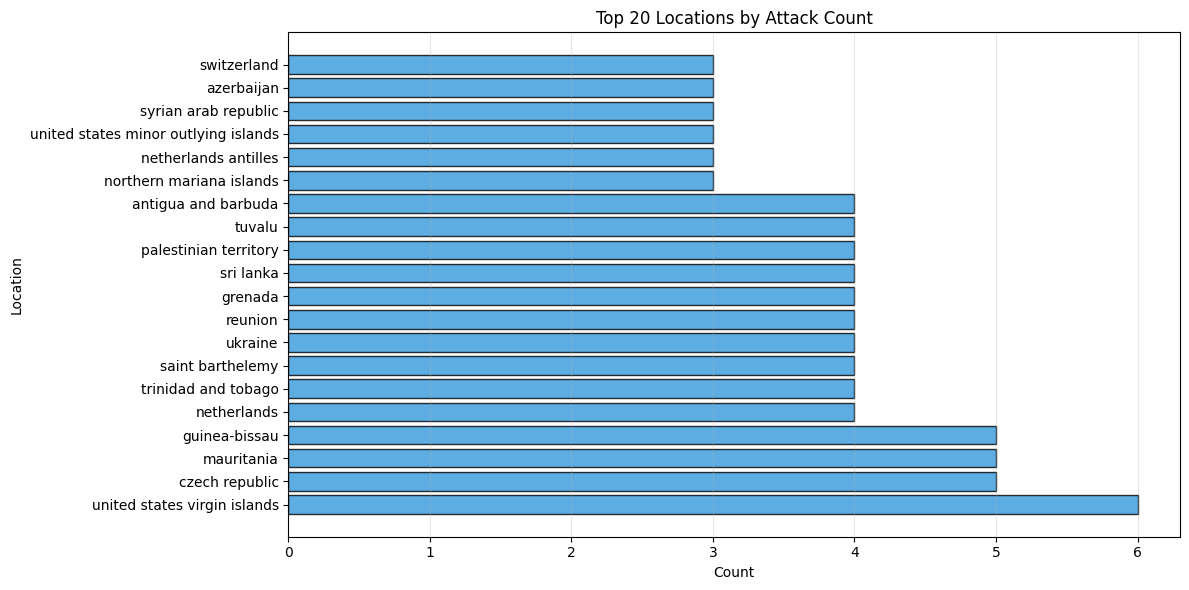


Total de ubicaciones únicas: 181


In [17]:
location_counts = df.groupBy("location").count().orderBy(col("count").desc()).limit(20).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(location_counts["location"], location_counts["count"], color="#3498db", edgecolor="black", alpha=0.8)
plt.title("Top 20 Locations by Attack Count")
plt.xlabel("Count")
plt.ylabel("Location")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal de ubicaciones únicas: {df.select('location').distinct().count()}")

## Análisis de Correlación

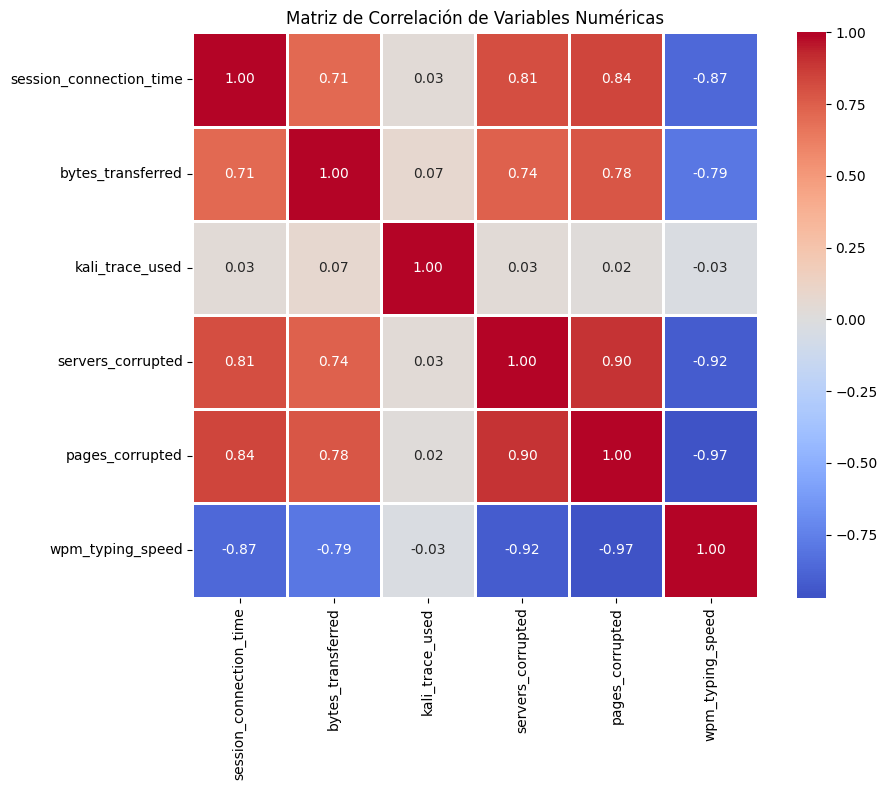

In [18]:
correlation_cols = ["session_connection_time", "bytes_transferred", "kali_trace_used",
                    "servers_corrupted", "pages_corrupted", "wpm_typing_speed"]

# Convertir a pandas para la matriz de correlación
pdf_corr = df.select(correlation_cols).toPandas()
corr_matrix = pdf_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            square=True, linewidths=1)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.tight_layout()
plt.show()

La matriz de correlación nos permite identificar relaciones entre variables que podrían ser importantes para el clustering. Variables altamente correlacionadas podrían indicar redundancia, mientras que variables con baja correlación pueden aportar información única.

## Análisis de Pares de Variables

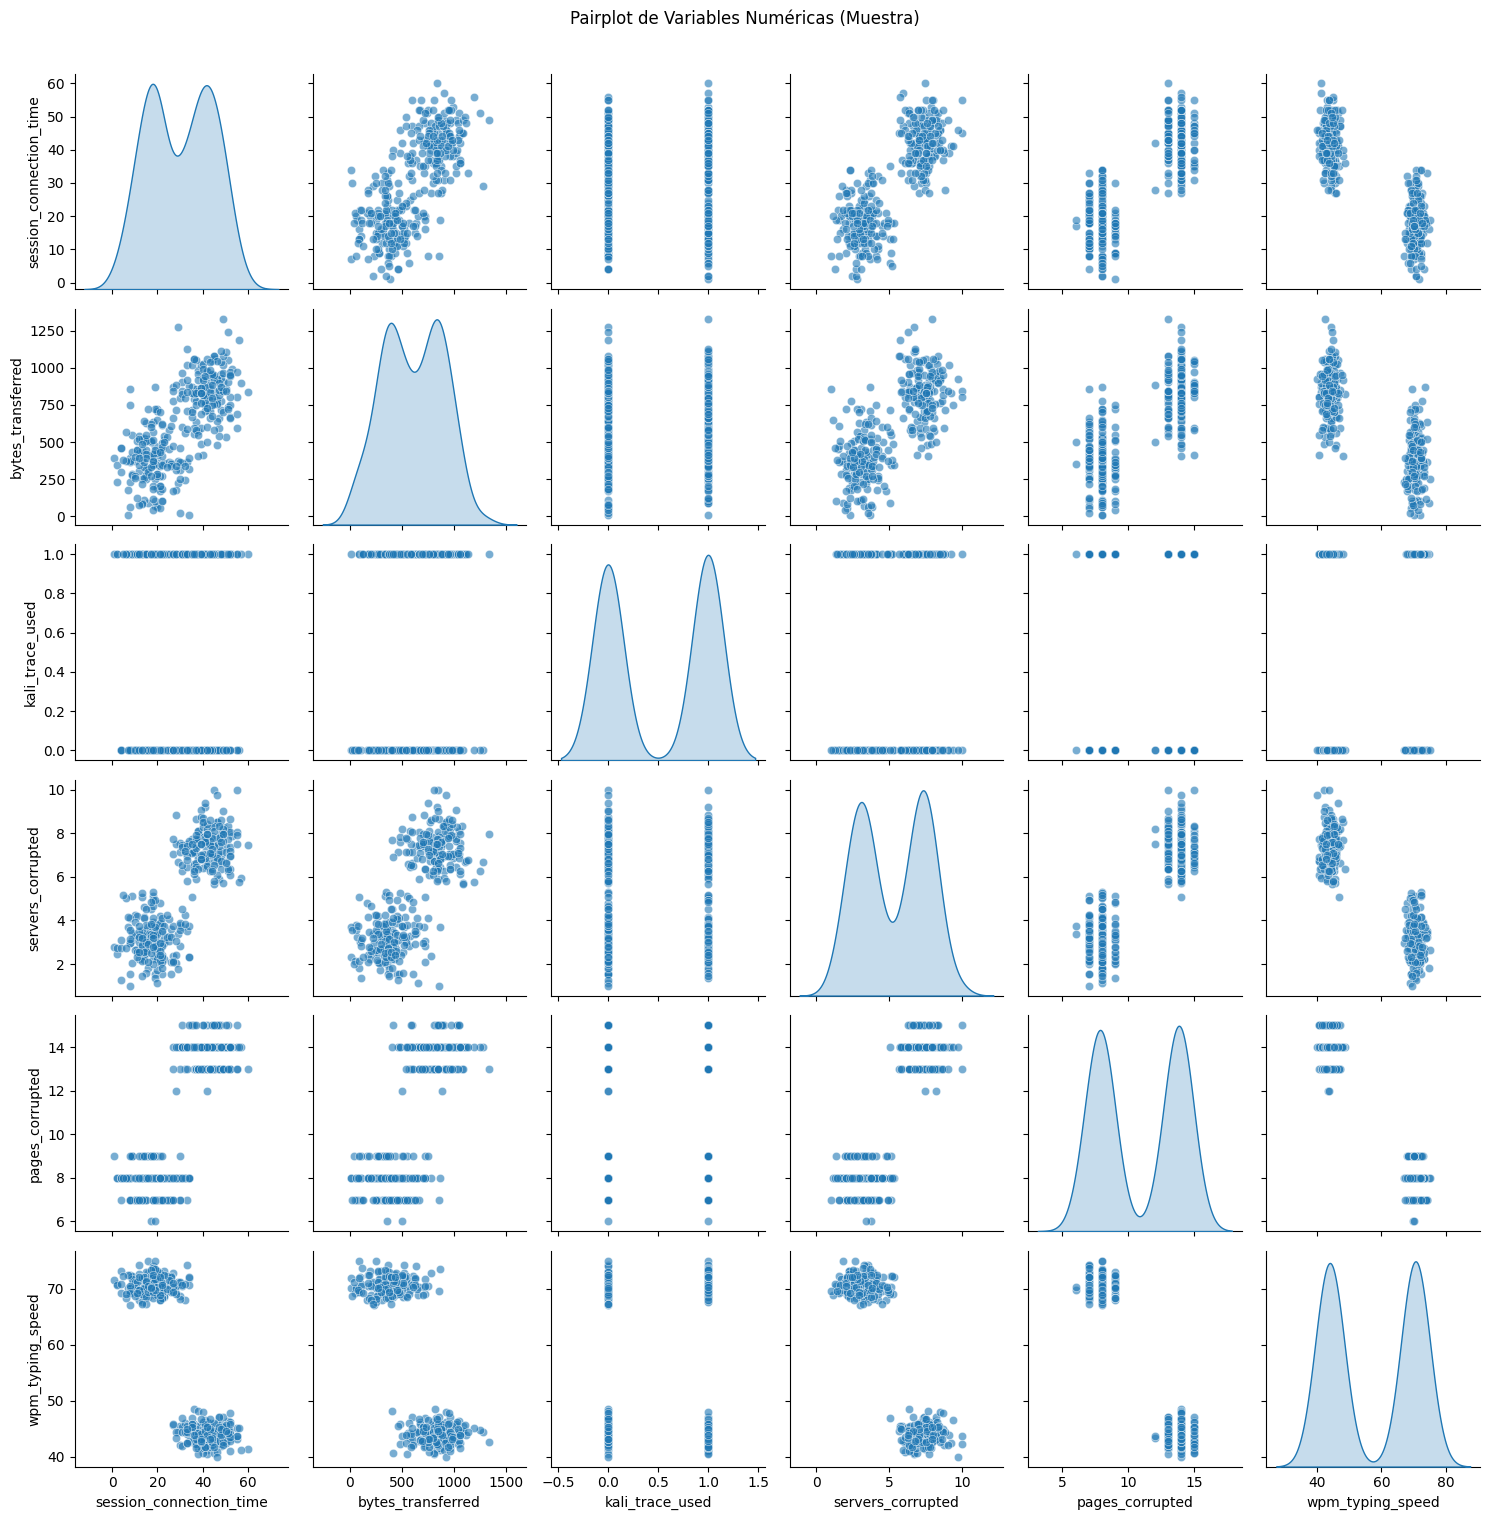

In [19]:
# Seleccionar una muestra para el pairplot (para mejor rendimiento)
total_rows = df.count()
sample_size = 500 if total_rows > 500 else total_rows
pdf_sample = df.select(correlation_cols).sample(False, sample_size / total_rows, seed=42).toPandas()

# Crear pairplot
sns.pairplot(pdf_sample, diag_kind="kde", plot_kws={"alpha": 0.6})
plt.suptitle("Pairplot de Variables Numéricas (Muestra)", y=1.01)
plt.tight_layout()
plt.show()

El pairplot nos permite visualizar las relaciones entre pares de variables, lo cual es útil para identificar patrones y posibles grupos en los datos antes de aplicar algoritmos de clustering.

## Detección de Outliers

### Análisis de Outliers por Variable
Vamos a identificar outliers utilizando el método IQR (Interquartile Range) para cada variable numérica.

In [20]:
from pyspark.sql.functions import col, percentile_approx

numeric_features = ["session_connection_time", "bytes_transferred", "servers_corrupted",
                    "pages_corrupted", "wpm_typing_speed"]

print("Análisis de Outliers por Variable:")
print("=" * 80)

for feature in numeric_features:
    # Calcular Q1, Q3 e IQR
    quantiles = df.approxQuantile(feature, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Contar outliers
    outliers_count = df.filter((col(feature) < lower_bound) | (col(feature) > upper_bound)).count()
    total_count = df.count()
    outlier_percentage = (outliers_count / total_count) * 100
    
    print(f"\n{feature}:")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Outliers: {outliers_count} ({outlier_percentage:.2f}%)")

Análisis de Outliers por Variable:

session_connection_time:
  Q1: 18.00
  Q3: 42.00
  IQR: 24.00
  Lower Bound: -18.00
  Upper Bound: 78.00
  Outliers: 0 (0.00%)

bytes_transferred:
  Q1: 366.50
  Q3: 842.59
  IQR: 476.09
  Lower Bound: -347.63
  Upper Bound: 1556.72
  Outliers: 0 (0.00%)

servers_corrupted:
  Q1: 3.07
  Q3: 7.39
  IQR: 4.32
  Lower Bound: -3.41
  Upper Bound: 13.87
  Outliers: 0 (0.00%)

pages_corrupted:
  Q1: 8.00
  Q3: 14.00
  IQR: 6.00
  Lower Bound: -1.00
  Upper Bound: 23.00
  Outliers: 0 (0.00%)

wpm_typing_speed:
  Q1: 44.04
  Q3: 70.57
  IQR: 26.53
  Lower Bound: 4.25
  Upper Bound: 110.36
  Outliers: 0 (0.00%)


Basado en el análisis de outliers, tomaremos decisiones sobre si removerlos o mantenerlos. En el contexto de clustering, los outliers pueden representar grupos interesantes de atacantes con comportamientos únicos, por lo que debemos ser cuidadosos al decidir si eliminarlos.

## Resumen Estadístico

In [21]:
print("Resumen Estadístico de Variables Numéricas:")
print("=" * 80)
df.select(correlation_cols).describe().show()

Resumen Estadístico de Variables Numéricas:
+-------+-----------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|session_connection_time| bytes_transferred|   kali_trace_used|servers_corrupted|   pages_corrupted|  wpm_typing_speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|                    334|               334|               334|              334|               334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|              40.0|
|    max|                   60.0|            1330.5|        

In [22]:
# Detener sesión de Spark
spark.stop()